In [1]:
!git clone https://github.com/susannapaoli/multimodal-memes.git

fatal: destination path 'multimodal-memes' already exists and is not an empty directory.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install -q transformers

In [4]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import sys
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
import json

sys.path.append('/content/multimodal-memes/BERT')
sys.path.append('/content/multimodal-memes/Utils')
sys.path.append('/content/multimodal-memes/JSON Data')

from dataloader import mydataset 
from plot_curves import plot_loss, plot_acc
from unimodal_trainer import train, validation

'''
For BERT
'''
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


**Upload data**

In [6]:
%cd /content/multimodal-memes/JSON Data

/content/multimodal-memes/JSON Data


In [ ]:
#with open('train.jsonl', 'r') as f:
    #lines = f.readlines()

#split_idx = int(0.8*len(lines))
#train_lines = lines[:split_idx]
#val_lines = lines[split_idx:]

In [ ]:
#with open('training.json', 'w') as f:
  #for line in lines[:split_idx]:
   # f.write(line)

#with open('validation.json', 'w') as f:
  #for line in lines[split_idx:]:
    #f.write(line)


In [7]:
trainlist = 'train.jsonl'
validlist = 'test_seen.jsonl'

In [8]:
train_dataset = mydataset(trainlist, name='train')          
train_dataloader = data.DataLoader(train_dataset, shuffle= True, batch_size = 32, num_workers=16,pin_memory=True)
validation_dataset = mydataset(validlist, name='valid')         
validation_dataloader = data.DataLoader(validation_dataset, shuffle=False, batch_size = 32, num_workers=16,pin_memory=True)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg

**Model Definition**

In [9]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", #12-layer BERT model, with an uncased vocab.
    num_labels = 2, #Binary classification
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

#model = model.to(device)
model = nn.DataParallel(model).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

**Hyperparameters**

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)
num_Epochs = 10
total_steps = len(train_dataloader) * num_Epochs
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0,  num_training_steps = total_steps)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [11]:
modelname = 'BERT_basic'
modelpath = './saved_model_checkpoints/'+modelname

In [12]:
writer = SummaryWriter(modelname)

train_loss, v_loss, v_acc = train(model, train_dataloader, validation_dataloader, criterion, optimizer, lr_scheduler, modelpath, writer, device, epochs = num_Epochs)

writer.flush()
writer.close()

Epoch:  1
training loss =  0.5514884644881227
Validation Loss: 0.7329	Validation Accuracy: 0.5920
Epoch:  2
training loss =  0.45520603964875517
Validation Loss: 0.7051	Validation Accuracy: 0.6050
Epoch:  3
training loss =  0.383486461762647
Validation Loss: 0.9225	Validation Accuracy: 0.5870
Epoch:  4
training loss =  0.3212797991315225
Validation Loss: 0.9749	Validation Accuracy: 0.5970
Epoch:  5
training loss =  0.26801436437868087
Validation Loss: 1.2907	Validation Accuracy: 0.5830
Epoch:  6
training loss =  0.2371514411012929
Validation Loss: 1.2588	Validation Accuracy: 0.5870
Epoch:  7
training loss =  0.2111370487320692
Validation Loss: 1.5078	Validation Accuracy: 0.5850
Epoch:  8
training loss =  0.19613129220188671
Validation Loss: 1.4861	Validation Accuracy: 0.5870
Epoch:  9
training loss =  0.18583968369276227
Validation Loss: 1.7129	Validation Accuracy: 0.5780
Epoch:  10
training loss =  0.17400674365068736
Validation Loss: 1.7495	Validation Accuracy: 0.5770


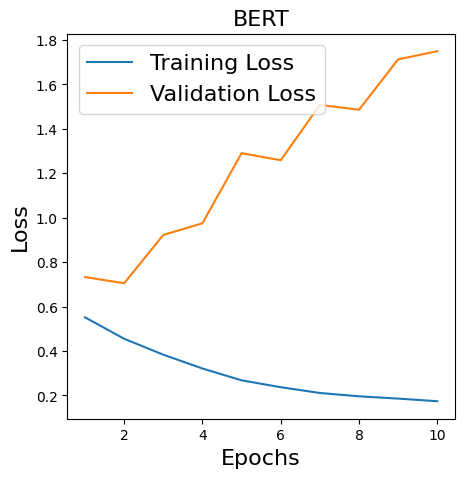

In [14]:
plot_loss(num_Epochs, train_loss, v_loss, 'BERT')

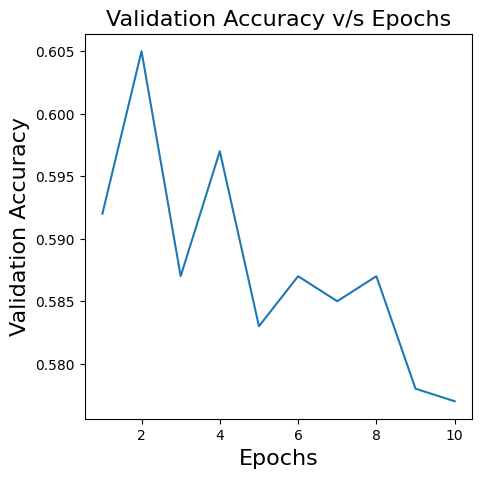

In [15]:
plot_acc(num_Epochs, v_acc)